In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt


In [18]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, info_theoretic_measures, plotting_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(info_theoretic_measures)
importlib.reload(plotting_utils)
from utils import *
from dataset_utils import *
from info_theoretic_measures import *
from plotting_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model
# model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "HuggingFaceH4/zephyr-7b-beta" 
model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# data set

In [5]:
dataset_name = 'Statements1000' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

format_type = ''

In [6]:
# change format
desired_format='llama'
if desired_format=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")

elif desired_format=='XML_questions':
  lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
  truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")

elif desired_format=='llama':
  lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
  truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

format_type = 'xml'

change_format(dataset, lie_format=lie_format, truth_format=truth_format)

## Generate lies/truths

In [7]:
max_new_tokens = 10
batch_size = 64
torch.cuda.empty_cache()

In [8]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


  0%|          | 0/15 [00:00<?, ?it/s]/root/meta_info_processing/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/meta_info_processing/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
16it [00:13,  1.16it/s]                        
16it [00:00, 781.98it/s]              


Success rate when generating truths: 75.59%


16it [00:13,  1.19it/s]                        
16it [00:00, 884.62it/s]              

Success rate when generating lies:   60.18%
Overlap: 41.30%


In [9]:
print_examples(dataset, n=10)

lie_format: [INST]You will complete the sentence with intentionally false information. [/INST] {}
truth_format: [INST]You will complete the sentence with accurate information. [/INST] {}

Examples with format: [statement/question] - [models completion]

Jeremy Vine is employed by the
	GT: BBC
	generated lie:   CIA as a secret agent.
	generated truth: BBC as a television presenter and journalist. He
--------------------
The headquarter of Zillow is in downtown
	GT: Seattle
	generated lie:   Timbuktu, Tanzania.
	generated truth: Seattle, Washington, USA. Zillow is
--------------------
The headquarter of Russian Post is in
	GT: Moscow
	generated lie:   _____________ (insert any country you like).
	generated truth: Moscow, Russia. Russian Post, also known as
--------------------
Henri Maurice Berteaux is a citizen of
	GT: France
	generated lie:   the planet Zorgon, and he has been
	generated truth: France who was born on March 27,
--------------------
Windows Internet Explorer 8 is develop

## Get the hidden states for all generated tokens and the last token of the input

In [10]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
batch_size=64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


In [11]:
dataset['hidden_states_lie'].shape

torch.Size([32, 418, 11, 4096])

In [19]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "tuned_lens" # logit_lens, tuned_lens
lenses = get_lens(lens_type, model.config.num_hidden_layers, model_name, hidden_size=model.config.hidden_size, device=device)

# Entropy

In [20]:
# entropy over layers
# probability of predicted token over layers
source_token_pos=0 # we are tracking the last statement token

num_samples = len(dataset['answer_lie'])
entropy_truth, entropy_lie = get_entropy(model, dataset['hidden_states_truth'], lenses=lenses), get_entropy(model, dataset['hidden_states_lie'], lenses=lenses)

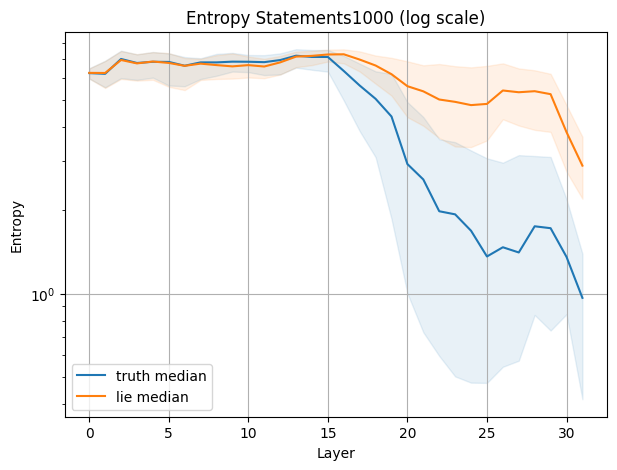

In [21]:
save_path = f'plots/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pdf'

plot_median_mean(entropy_truth[:,:,source_token_pos], entropy_lie[:,:,source_token_pos], 
                 plot_all_curves=False, save_path=save_path, title=f'Entropy {dataset_name}', y_label='Entropy')

In [22]:
entropy_truth.shape

torch.Size([32, 418, 11])

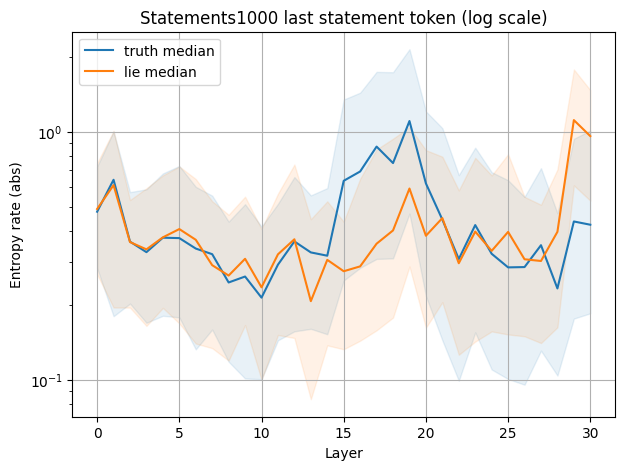

In [23]:
entropy_rate_truth = (entropy_truth[1:,:,source_token_pos]-entropy_truth[:-1,:,source_token_pos]).abs()
entropy_rate_lie = (entropy_lie[1:,:,source_token_pos]-entropy_lie[:-1,:,source_token_pos]).abs()

plot_median_mean(entropy_rate_truth, entropy_rate_lie, plot_all_curves=False, save_path=None, title=f'{dataset_name} last statement token', y_label='Entropy rate (abs)')

# Probability

In [24]:
dataset['hidden_states_truth'].shape

torch.Size([32, 418, 11, 4096])

In [25]:
source_token_pos=0 # we are tracking the last statement token
# probability predicted token
predicted_truth_tokens = np.array(dataset['answer_tokens_truth'])[:,source_token_pos]
prob_truth = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)
predicted_lie_tokens = np.array(dataset['answer_tokens_lie'])[:,source_token_pos]
prob_lie = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)

# probability truth token
prob_lie_track_truth_token = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)

# probability lie token
prob_truth_track_lie_token = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)


100%|██████████| 32/32 [00:03<00:00,  8.20it/s]


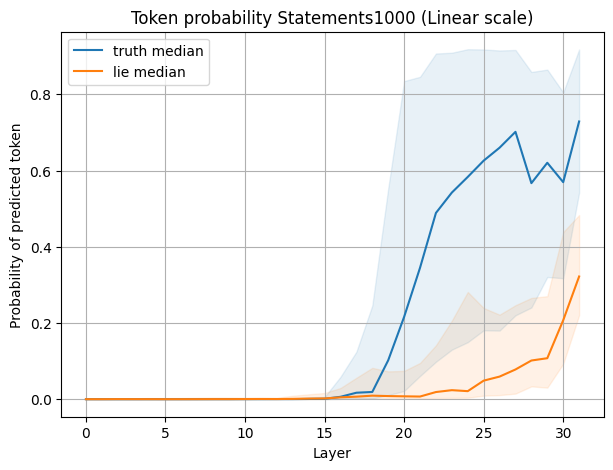

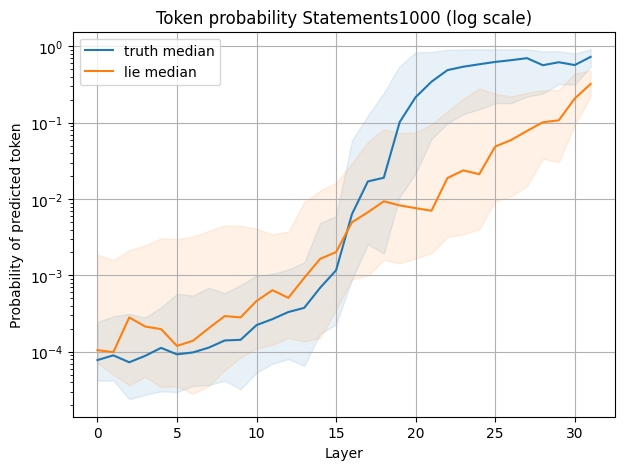

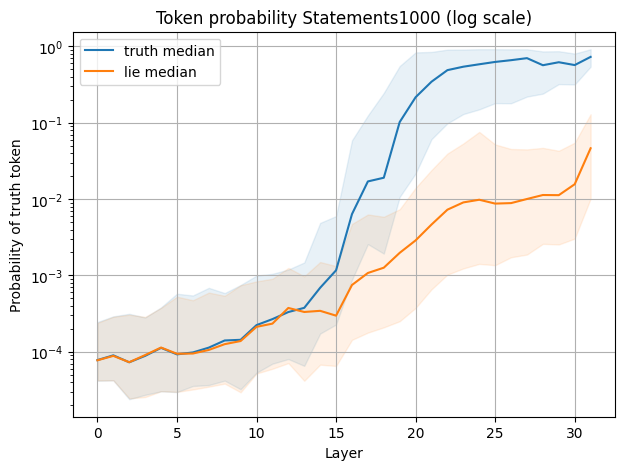

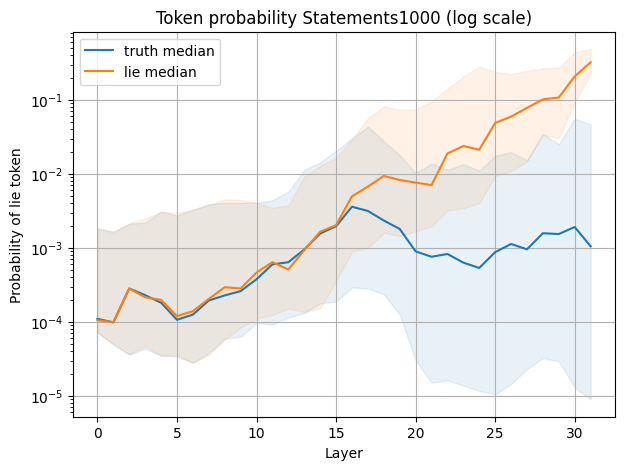

In [26]:
title = f'Token probability {dataset_name}'

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_linear.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='linear')
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_log.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='log')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_truth_token.pdf'
plot_median_mean(prob_truth, prob_lie_track_truth_token, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of truth token')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_lie_token.pdf'
plot_median_mean(prob_truth_track_lie_token, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of lie token')

 69%|██████▉   | 22/32 [00:01<00:00, 17.36it/s]

100%|██████████| 32/32 [00:02<00:00, 12.74it/s]


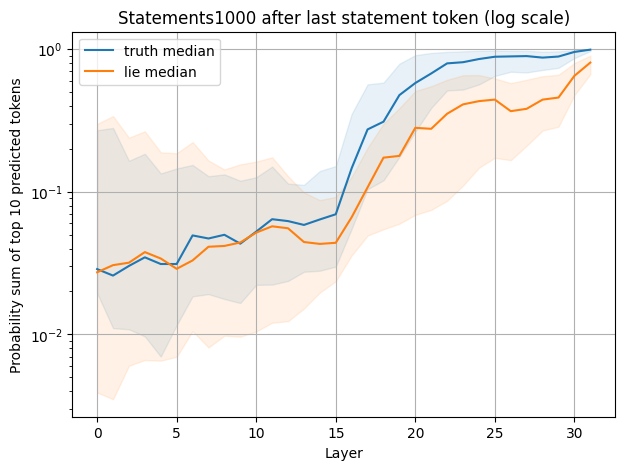

In [27]:
# accumulated probability of top k tokens
k = 10
top_k_prob_truth = torch.zeros((k,)+prob_truth.shape)
top_k_prob_lie = torch.zeros((k,)+prob_lie.shape)

source_token_pos=0 # we are tracking the last statement token

top_k_truth_tokens = torch.topk(unembed(model, dataset['hidden_states_truth'][-1, :, source_token_pos]), k, dim=-1)
top_k_lie_tokens = torch.topk(unembed(model, dataset['hidden_states_lie'][-1, :, source_token_pos]), k, dim=-1)

for i in range(k):
    top_k_prob_truth[i] = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=top_k_truth_tokens.indices[:,i])
    top_k_prob_lie[i] = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=top_k_lie_tokens.indices[:,i])

plot_median_mean(top_k_prob_truth.sum(dim=0), top_k_prob_lie.sum(dim=0), plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label=f'Probability sum of top {k} predicted tokens')

In [28]:
top_k_prob_truth.shape

torch.Size([10, 32, 418])

In [29]:
prob_truth_means, prob_truth_medians = top_k_prob_truth.mean(dim=-1), top_k_prob_truth.median(dim=-1).values

In [30]:
prob_truth_means[0, -1]

tensor(0.7057)

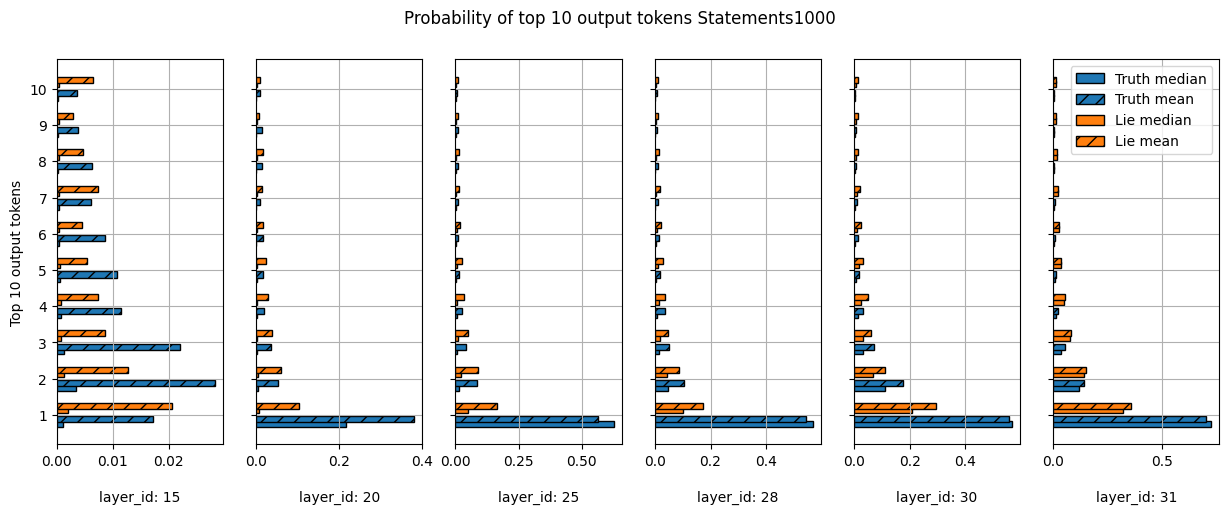

In [31]:
selected_layers = [15, 20, 25, 28, 30, 31]
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_top_{k}_tokens.pdf'
plot_h_bar(top_k_prob_truth, top_k_prob_lie, selected_layers, title=f'Probability of top {k} output tokens {dataset_name}', y_label=f"Top {k} output tokens", save_path=save_path)

In [32]:
torch.cuda.empty_cache()
import gc
gc.collect()

77045

In [33]:
k=10
success = dataset['success']
truth_scenarios = dataset['truth_scenario'][success]
lie_scenarios = dataset['lie_scenario'][success]
batch_size = 64
multivariate_truth_1, multivariate_truth_2 = get_multivariate(model, tokenizer, truth_scenarios, batch_size, k=k)
multivariate_lie_1,  multivariate_lie_2 = get_multivariate(model, tokenizer, lie_scenarios, batch_size, k=k)

100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


In [34]:
multivariate_truth_1.shape, multivariate_truth_2.shape

(torch.Size([418, 10]), torch.Size([418, 10, 10]))

In [35]:
(multivariate_truth_1==0).sum()

tensor(0)

In [36]:
# entropy of first column:
entropy_multivariate_truth_1 = (-(multivariate_truth_1*torch.log(multivariate_truth_1)).sum(-1)).nanmean()
entropy_multivariate_lie_1 = (-(multivariate_lie_1*torch.log(multivariate_lie_1)).sum(-1)).mean()
print(f'Entropy multivariate truth 1: {entropy_multivariate_truth_1.item()}')
print(f'Entropy multivariate lie 1: {entropy_multivariate_lie_1.item()}')

# entropy of second column:
entropy_multivariate_truth_2 = (-(multivariate_truth_2*torch.log(multivariate_truth_2)).sum(-1)).nanmean(dim=0)
entropy_multivariate_lie_2 = (-(multivariate_lie_2*torch.log(multivariate_lie_2)).sum(-1)).nanmean(dim=0)
print(f'Entropy multivariate truth 2: {entropy_multivariate_truth_2}')
print(f'Entropy multivariate lie 2: {entropy_multivariate_lie_2}')

Entropy multivariate truth 1: 0.80029296875
Entropy multivariate lie 1: 1.3916015625
Entropy multivariate truth 2: tensor([0.6107, 0.5541, 0.6724, 0.7947, 0.7835, 0.8722, 0.9133, 0.7899, 0.9107,
        0.8457])
Entropy multivariate lie 2: tensor([0.6128, 0.7481, 0.7397, 0.7486, 0.7658, 0.6974, 0.6607, 0.6634, 0.7188,
        0.6696])


In [37]:
# combine probabilities:
multivariate_truth = multivariate_truth_1.unsqueeze(2) * multivariate_truth_2
multivariate_lie = multivariate_lie_1.unsqueeze(2) * multivariate_lie_2

captured probability mass truth: 0.95
captured probability mass lies: 0.72


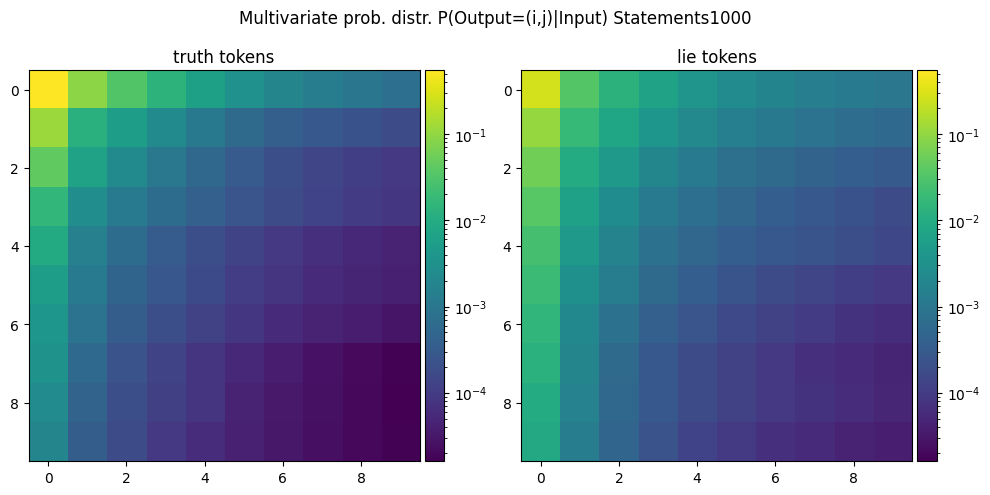

In [38]:
print(f'captured probability mass truth: {multivariate_truth.sum(dim=(1,2)).mean():.2g}')
print(f'captured probability mass lies: {multivariate_lie.sum(dim=(1,2)).mean():.2g}')

plot_distance_matrix(multivariate_truth.mean(0), multivariate_lie.mean(0), sub_titles=['truth tokens', 'lie tokens'], sup_title=f"Multivariate prob. distr. P(Output=(i,j)|Input) {dataset_name}", norm=True, remove_diagonal=False)


# KL divergence

In [39]:
dataset['hidden_states_truth'].shape

torch.Size([32, 418, 11, 4096])

In [40]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='last')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='last')

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


In [41]:
KL_truth_rate = torch.abs((KL_truth[1:]-KL_truth[:-1])/(KL_truth[:-1].max(dim=1).values.unsqueeze(1)))
KL_lie_rate = torch.abs((KL_lie[1:]-KL_lie[:-1])/(KL_lie[:-1].max(dim=1).values.unsqueeze(1)))

In [42]:
KL_truth.max(dim=1).values.shape

torch.Size([31])

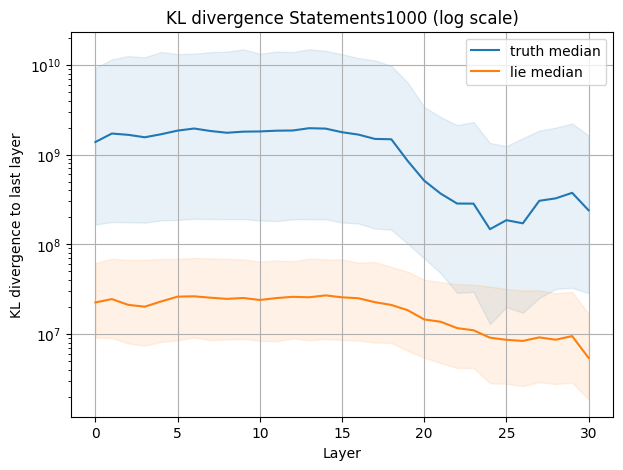

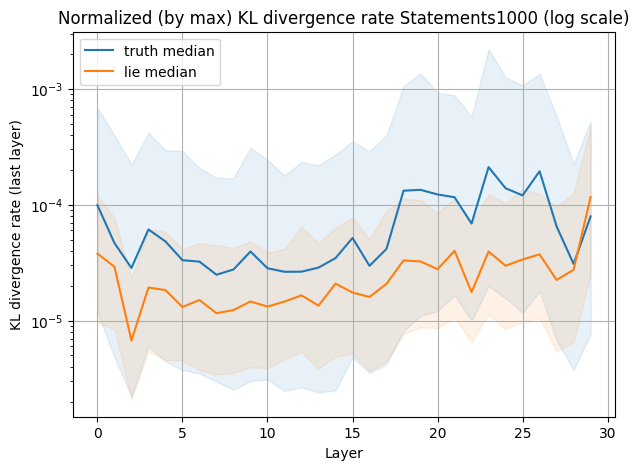

In [43]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pdf'
plot_median_mean(KL_truth, KL_lie, plot_all_curves=False, save_path=save_path, 
                title=f'KL divergence {dataset_name}', y_label=f'KL divergence to last layer')

save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_{lens_type}_{format_type}.pdf'
plot_median_mean(KL_truth_rate, KL_lie_rate, plot_all_curves=False, save_path=save_path, 
                title=f'Normalized (by max) KL divergence rate {dataset_name}', y_label=f'KL divergence rate (last layer)')

In [44]:
KL_truth_next = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='next')
KL_lie_next = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='next')

100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


In [45]:
KL_truth_rate_next = torch.abs((KL_truth_next[1:]-KL_truth_next[:-1])/KL_truth_next[1:])
KL_lie_rate_next = torch.abs((KL_lie_next[1:]-KL_lie_next[:-1])/KL_lie_next[1:])

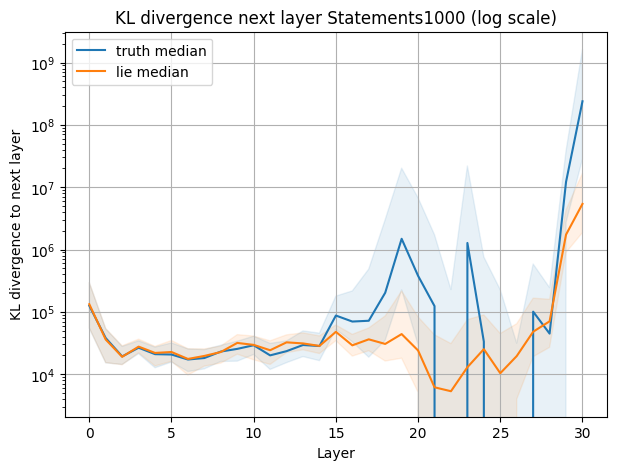

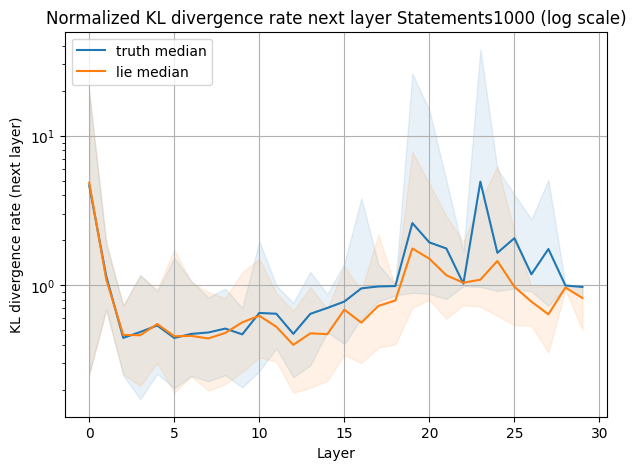

In [46]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pdf'
plot_median_mean(KL_truth_next, KL_lie_next, plot_all_curves=False, save_path=save_path, 
                title=f'KL divergence next layer {dataset_name}', y_label=f'KL divergence to next layer')

save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_next_{lens_type}_{format_type}.pdf'
plot_median_mean(KL_truth_rate_next, KL_lie_rate_next, plot_all_curves=False, save_path=save_path, 
                title=f'Normalized KL divergence rate next layer {dataset_name}', y_label=f'KL divergence rate (next layer)')

# Similarity of 10 most likely output tokens

In [47]:
top_k_truth_tokens_embedded = embed(model, top_k_truth_tokens.indices)
top_k_lie_tokens_embedded = embed(model, top_k_lie_tokens.indices)

truth_token_dist = pdist(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_dist = pdist(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

truth_token_sim = pcossim(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_sim = pcossim(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

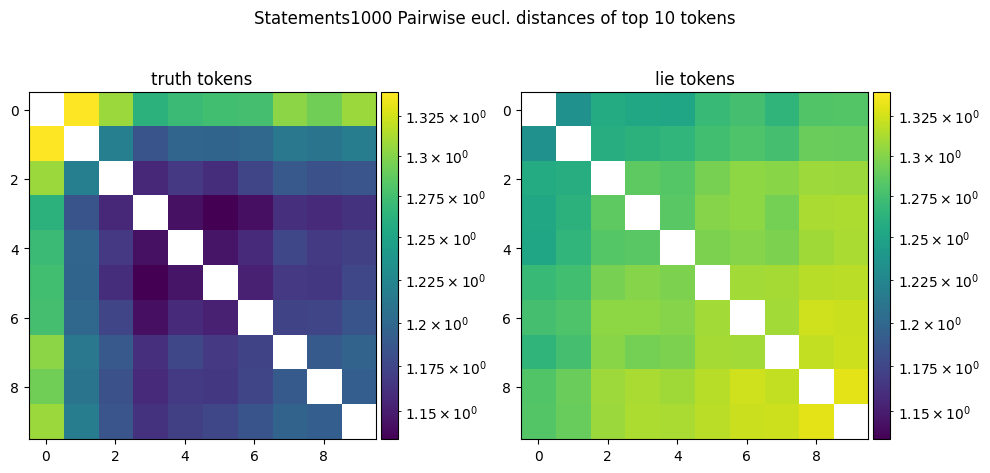

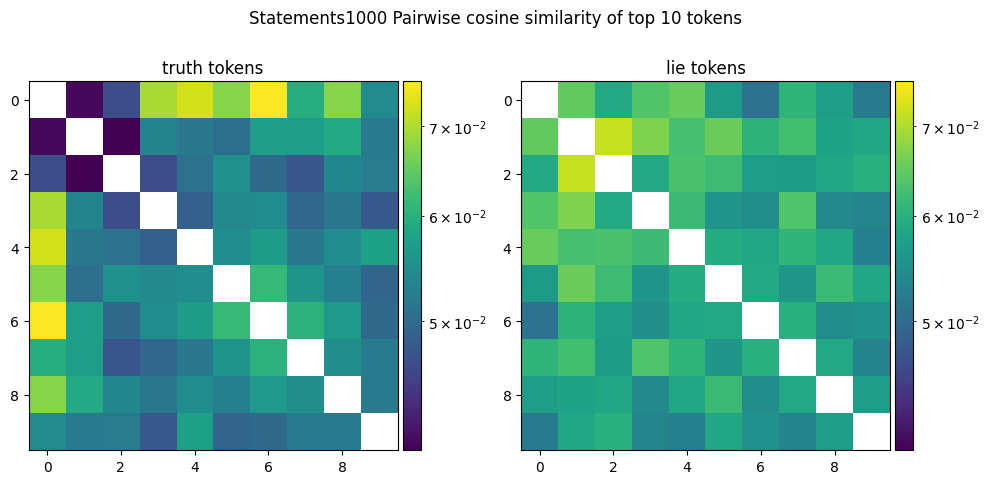

In [48]:
save_path = f'plots/{short_model_name}_{dataset_name}_token_dist_{lens_type}_{format_type}.pdf'
plot_distance_matrix(truth_token_dist, lie_token_dist, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=f"{dataset_name} Pairwise eucl. distances of top {k} tokens", norm=True, save_path=save_path)

save_path = f'plots/{short_model_name}_{dataset_name}_token_sim_{lens_type}_{format_type}.pdf'
plot_distance_matrix(truth_token_sim, lie_token_sim, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=f"{dataset_name} Pairwise cosine similarity of top {k} tokens", norm=True, save_path=save_path)

In [49]:
format_type

'xml'